Проект по анализу контента Netflix и простой контентной рекомендательной системе

🔹 **Цель:**  
- Проанализировать данные Netflix (жанры, оценки, годы).
- Реализовать рекомендацию похожих фильмов по описаниям.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

sns.set(style='darkgrid')


In [23]:
# Загрузка датасета
df = pd.read_csv("C:/Users/smirn/Downloads/archive (1)/netflix_tv_shows_detailed_up_to_2025.csv")
# Отбираем нужные колонки
cols = ['title', 'type', 'genres', 'country', 'release_year', 
        'vote_average', 'popularity', 'description']
df = df[cols]

# Очистка данных от NaN
df.dropna(subset=['genres', 'description', 'country'], inplace=True)

# Сброс индекса после очистки
df.reset_index(drop=True, inplace=True)

# Проверим данные
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11442 entries, 0 to 11441
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         11442 non-null  object 
 1   type          11442 non-null  object 
 2   genres        11442 non-null  object 
 3   country       11442 non-null  object 
 4   release_year  11442 non-null  int64  
 5   vote_average  11442 non-null  float64
 6   popularity    11442 non-null  float64
 7   description   11442 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 715.3+ KB


In [25]:
df.head()

,title,type,genres,country,release_year,vote_average,popularity,description
0,Running Man,TV Show,"Comedy, Reality",South Korea,2010,8.241,1929.898,A reality and competition show where members a...
1,Conan,TV Show,"Talk, Comedy, News",United States of America,2010,7.035,1670.580,A late night television talk show hosted by C...
2,MasterChef Greece,TV Show,Reality,Greece,2010,5.600,1317.092,MasterChef Greece is a Greek competitive cooki...
3,Prostřeno!,TV Show,Reality,Czech Republic,2010,6.500,1095.776,The knives (and forks) are out as a group of s...
4,The Talk,TV Show,Talk,"United States of America, Ireland",2010,3.400,712.070,A panel of well-known news and entertainment p...


## Exploratory Data Analysis

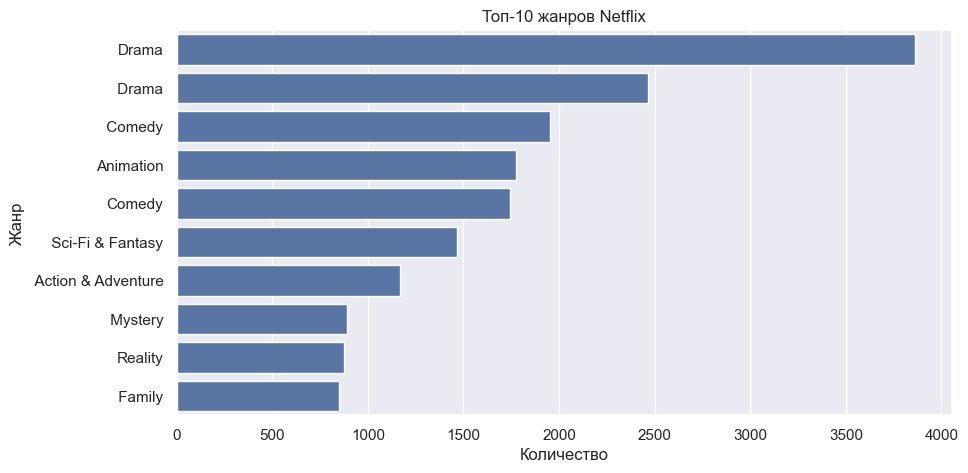

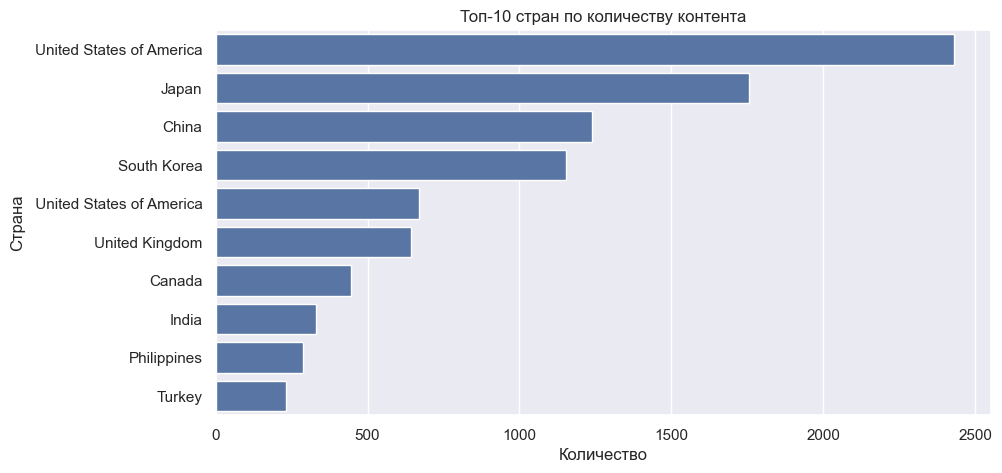

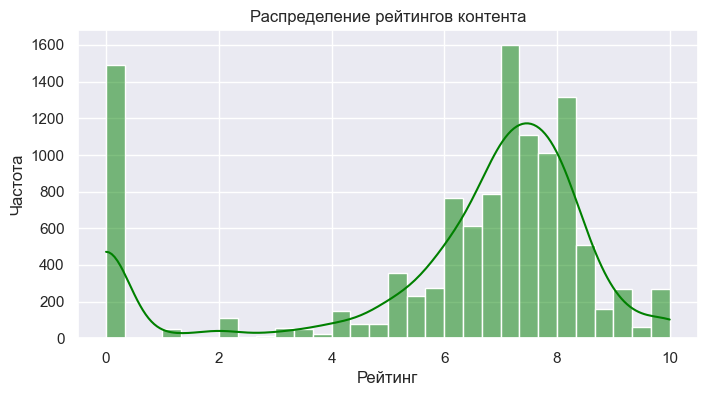

C:\Users\smirn\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


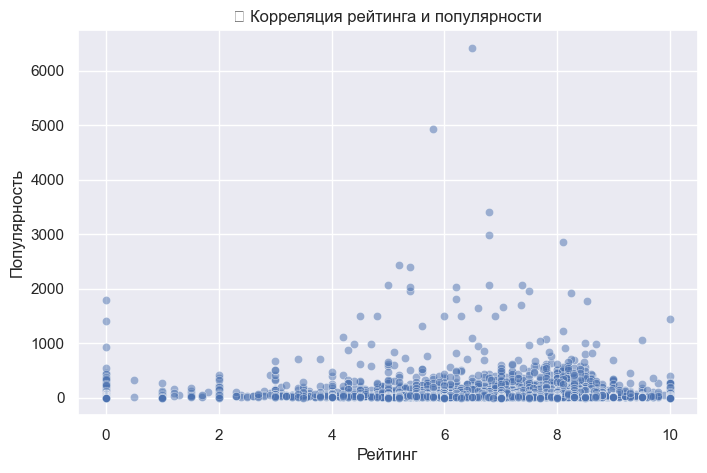

In [32]:
# Топ-10 жанров
plt.figure(figsize=(10,5))
sns.barplot(y=df['genres'].str.split(',').explode().value_counts().head(10).index,
            x=df['genres'].str.split(',').explode().value_counts().head(10).values)
plt.title('Топ-10 жанров Netflix')
plt.xlabel('Количество')
plt.ylabel('Жанр')
plt.show()

# Топ-10 стран производителей
plt.figure(figsize=(10,5))
top_countries = df['country'].str.split(',').explode().value_counts().head(10)
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Топ-10 стран по количеству контента')
plt.xlabel('Количество')
plt.ylabel('Страна')
plt.show()

# Распределение рейтингов
plt.figure(figsize=(8,4))
sns.histplot(df['vote_average'], bins=30, kde=True, color='green')
plt.title('Распределение рейтингов контента')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.show()

# Корреляция рейтинга и популярности
plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='vote_average', y='popularity', alpha=0.5)
plt.title('Корреляция рейтинга и популярности')
plt.xlabel('Рейтинг')
plt.ylabel('Популярность')
plt.show()


C:\Users\smirn\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


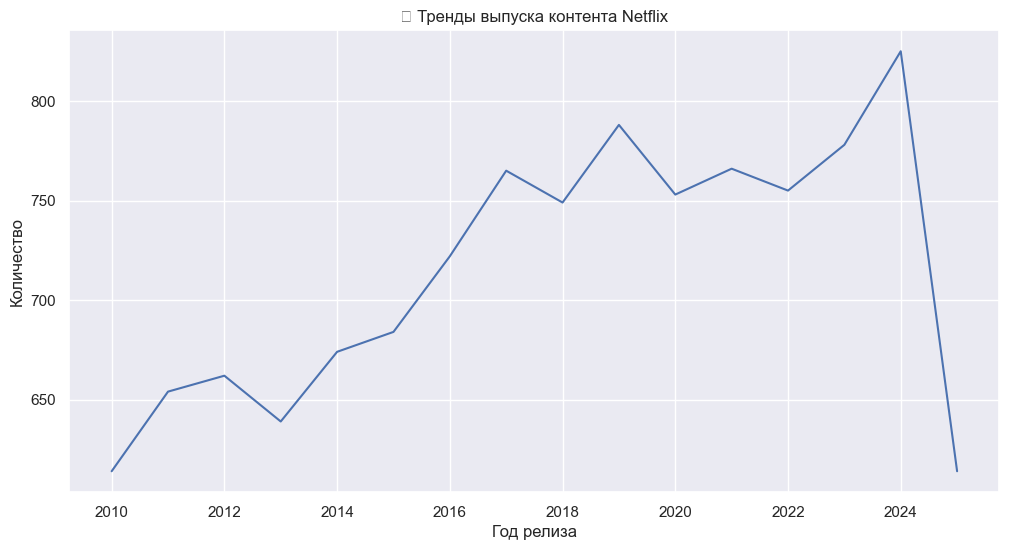

In [34]:
# Количество контента по годам
plt.figure(figsize=(12,6))
sns.lineplot(data=df.groupby('release_year').size())
plt.title('📈 Тренды выпуска контента Netflix')
plt.xlabel('Год релиза')
plt.ylabel('Количество')
plt.show()

## Рекомендательная система

In [49]:
# TF-IDF по описанию и жанрам
df['text_features'] = df['description'] + ' ' + df['genres']

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['text_features'])

# Cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Индексация
indices = pd.Series(df.index, index=df['title']).drop_duplicates()

# Функция рекомендаций
def recommend(title, cosine_sim=cosine_sim, df=df, indices=indices, top_n=5):
    if title not in indices:
        return f"Фильм '{title}' не найден."
    
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

    movie_indices = [i[0] for i in sim_scores]
    return df[['title', 'genres', 'vote_average']].iloc[movie_indices]

# Пример рекомендаций
recommend('Running Man')

,title,genres,vote_average
2692,Kunscht!,"Documentary, Reality",0.0
3878,Dance Kids,Reality,0.0
4592,MasterChef Celebrity,"Reality, Comedy",5.8
705,Real Girls in the Jungle,Reality,6.0
11409,Uncanny Post Mortem,Documentary,0.0


In [ ]:
## Недооценённые 

In [40]:
# Недооценённые фильмы с высоким рейтингом, но низкой популярностью
hidden_gems = df[(df['vote_average'] > 8) & (df['popularity'] < df['popularity'].quantile(0.5))]

hidden_gems[['title', 'vote_average', 'popularity', 'genres']].sort_values('vote_average', ascending=False).head(10)

,title,vote_average,popularity,genres
398,Journey to the West,10.0,21.622,Drama
11103,The Blank Menu for You,10.0,20.251,Reality
11111,An Update on Our Family,10.0,26.823,Documentary
486,Mori no Asagao,10.0,19.562,Drama
466,Ishq Gumshuda,10.0,23.161,Drama
9749,Raat Hone Ko Hai,10.0,27.822,Drama
9859,Charging Topspinner,10.0,22.311,"Animation, Kids, Action & Adventure, Comedy, S..."
9919,Battalion 101,10.0,21.246,"Drama, War & Politics"
9829,You Only Go Around Once,10.0,20.351,"Comedy, Family"
9793,Magda Louw,10.0,28.033,Comedy


##  Итоги проекта

- Проведён детальный анализ трендов по жанрам, странам и годам.
- Выявлены закономерности популярности и рейтингов.
- Создана рекомендательная система
- Найдены "скрытые жемчужины" Netflix (высокий рейтинг при низкой популярности).

